# Follow your signal through the telescope!

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy.signal
from IPython.display import Image
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from ipywidgets import interact, FloatSlider, Layout

## The incoming signal

Let's say the incoming signal is made up of 3 fourier components- one astronomical, one out of band man-made signal, and one in band man-made signal. We're trying to recover the real astronomical signal from this. 

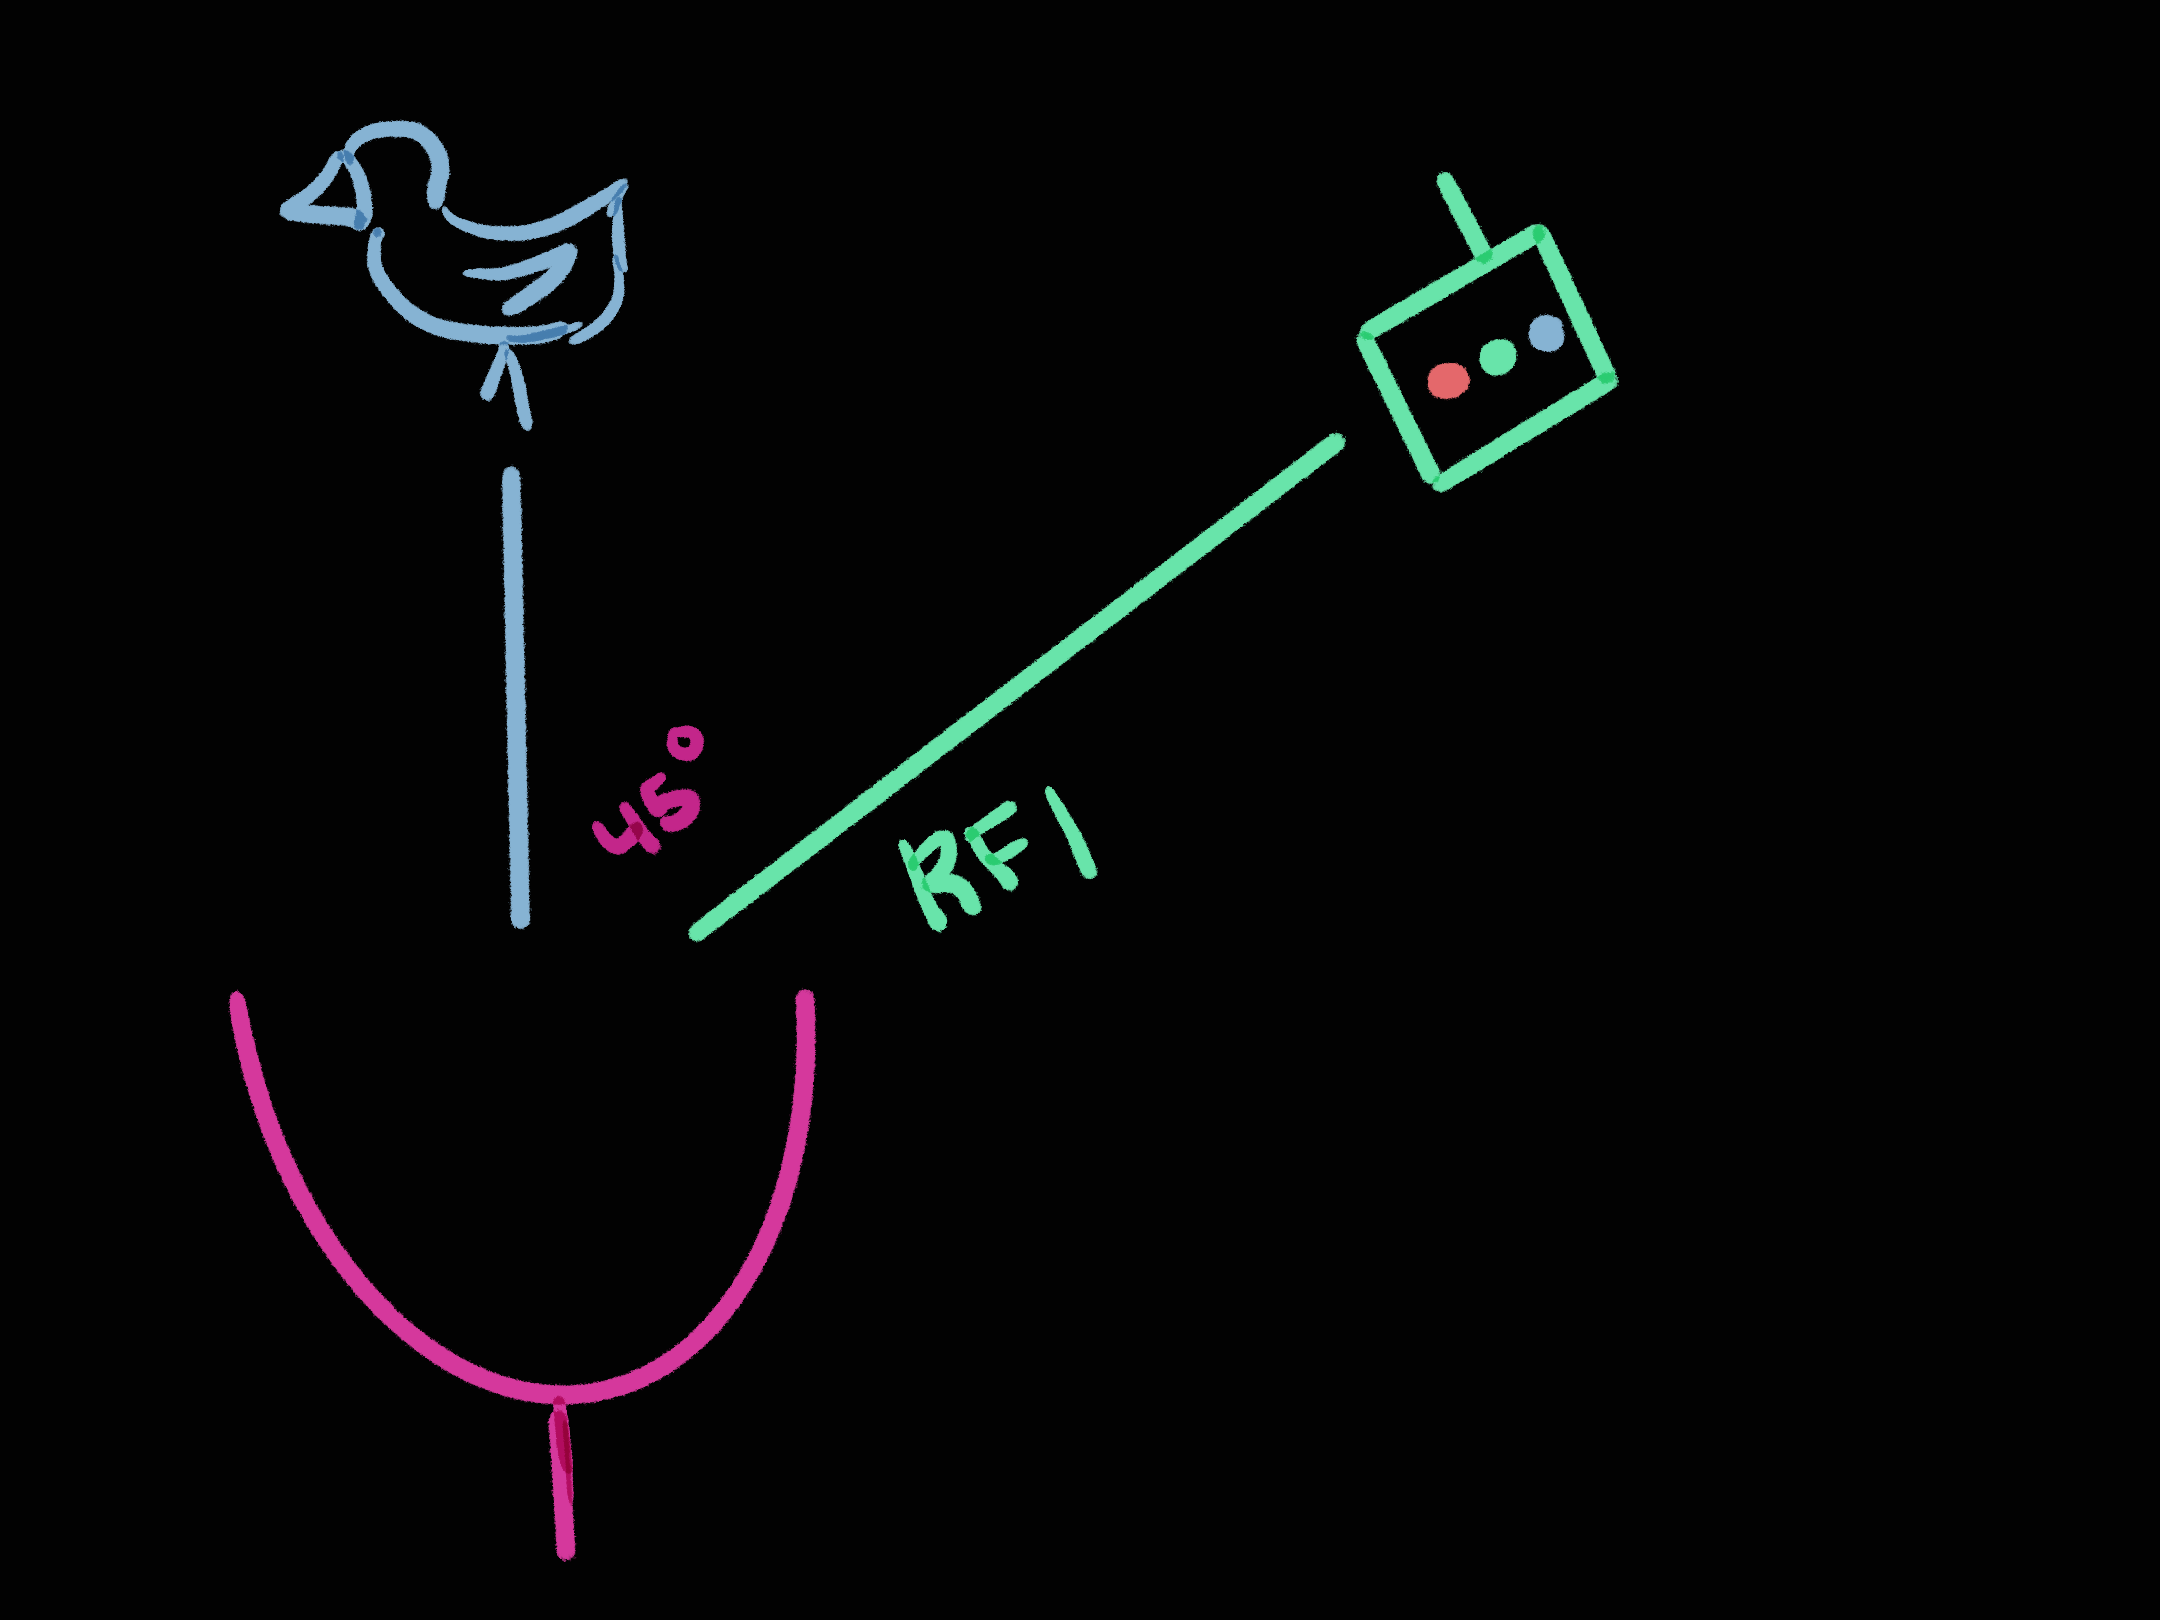

In [3]:
Image("champ1.png", width=500, height=500)

In [ ]:
time = np.arange(0, 10.24, 0.001)
amplitude2 = 3*np.sin(15*time)
amplitude3 = 7*np.cos(500*time)
amplitude1 = scipy.signal.chirp(time, f0=10, f1=5, t1=1, method='linear')

plt.plot(time, amplitude3, label = "Out of band RFI")
plt.plot(time, amplitude1, label = "Chirp")
plt.plot(time, amplitude2, label = "In band RFI")


plt.title('Sky Components')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.xlim(0,1)
plt.show()

What does this signal actually look like?

In [ ]:
sky = amplitude1 + amplitude2 + amplitude3
plt.plot(time, sky, label = "Sky")
plt.title('Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()

In [ ]:
plt.plot(np.fft.fft(sky))
plt.xlim(0,1000)
plt.xlabel('Channel #')
plt.title('FFT of total Sky signal')
plt.ylabel('Arbitrary Units')

In [ ]:
chirpfft = np.fft.fft(amplitude1)
plt.plot(np.fft.fft(amplitude1))
plt.xlim(0,500)
plt.xlabel('Channel #')
plt.title('FFT of Chirp signal')
plt.ylabel('Arbitrary Units')

## Antenna and Beam 

 Let's say your Chirp is directly above your telescope and the RFI is coming in at an angle. Add a large multiplicative gain to the chirp signal and a smaller gain to your in band RFI. 

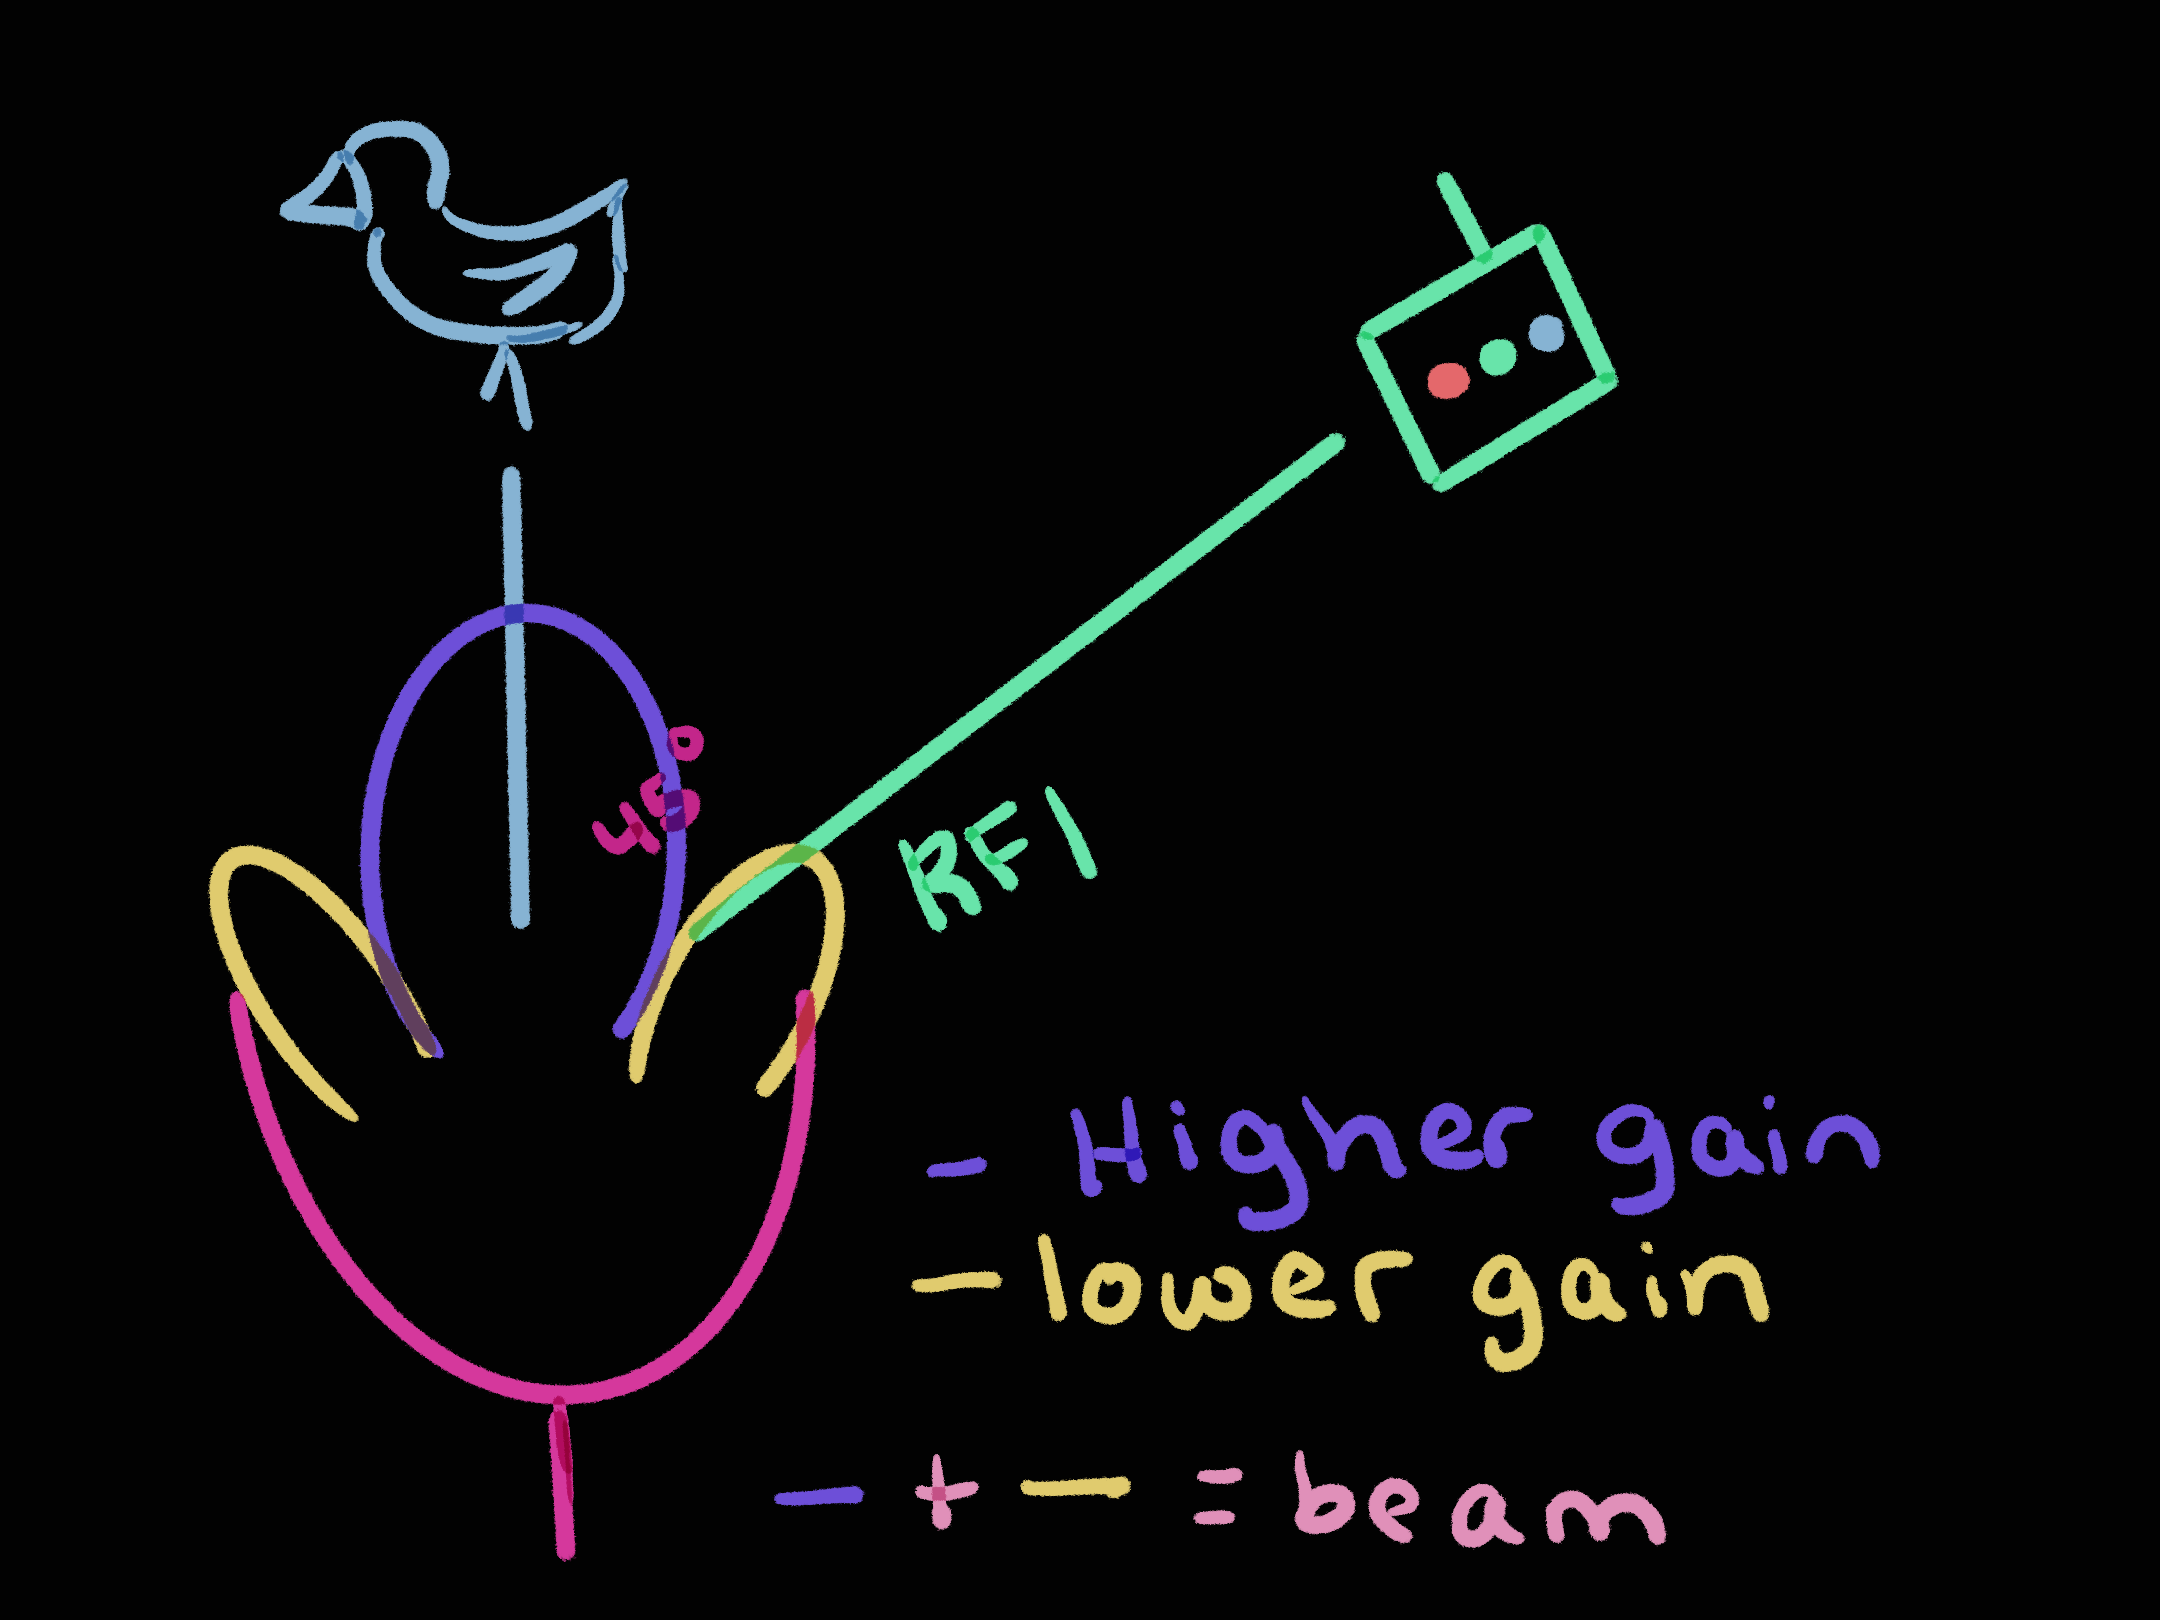

In [4]:
Image("champ2.png", width=500, height=500)

In [ ]:
gainlarge = 5
gainsmall = 2
voltages = gainlarge*amplitude1 + gainsmall*amplitude2 + amplitude3
plt.plot(time, voltages, label = "Sky")
plt.title('Signal modified by beam')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()

Now let's say our out of band RFI gets rejected by the antenna shape. Apply a multiplicative supression to the out of band rfi. 

In [ ]:
gainlarge = 5
gainsmall = 2
supression = .5
amplitude1 = gainlarge*amplitude1 
amplitude2 = gainsmall*amplitude2 
amplitude3 = supression*amplitude3
voltages = amplitude1 + amplitude2 + amplitude3
plt.plot(time, voltages, label = "Sky")
plt.title('Signal modified by beam')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()

How does this change your signal?

In [ ]:
plt.plot(np.fft.fft(voltages))
plt.xlabel('Channel #')
plt.title('FFT of Signal modified by beam')
plt.ylabel('Arbitrary Units')
plt.xlim(0,1000)

## Analog

### a. Amplification


We want a strong signal from the sky to be able to have enough sensitivity to detect changes in the signal. We apply some gain using an amplifier. First, we'll add some gaussian noise from our electronics, as this will also be amplified by any gain stages we have.

In [ ]:
rf = voltages + 3*np.random.normal(0,1,10240)
plt.plot(time, rf, label = "Sky")
plt.title('Signal Amplified')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()

We know we have some signals out of band that might interfere with our ability to detect our signal. Based on prior knowledge, we know our astronomical signal is at a specific frequency, so we design a filter to reject the out of band signals. This filter will suppress everything outside of the red lines in the FFT. For brevity of code, we assume it eliminates out of band signals entirely. A real analog filter will have some Db level of supression.

In [ ]:
plt.plot(np.fft.fft(rf))
#plt.plot(filter)
plt.xlim(0,1000)
plt.axvline(5, c='r')
plt.axvline(500, c='r')
plt.axvline()
plt.xlabel('Channel #')
plt.title('FFT of total Sky signal')
plt.ylabel('Arbitrary Units')

In [ ]:
filteredfft = np.fft.fft(rf)
for i in range(len(filteredfft)):
    if i > 500 or i < 5:
        filteredfft[i] = 0   
plt.plot(filteredfft)
plt.xlim(0,1000)
plt.xlabel('Channel #')
plt.title('FFT of total Sky signal')
plt.ylabel('Arbitrary Units')

In [ ]:
filteredrf = np.fft.ifft(filteredfft)
plt.plot(time, filteredrf, label = "filtered signal")
plt.title('Signal Filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()

## Digital

### a. ADCs

We need to digitize our signal. Let's say we have an 8 bit ADC sampling at 10 samples/second, with an input voltage range of +/- 15 volts. Calculate the voltage sensitivity. Will we be able to resolve our chirp?

In [ ]:
plt.plot(time, filteredrf)
plt.title('Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.xlim(0,1)
plt.show()

In [ ]:
samples = filteredrf[::10]
x= np.arange(0,1024,1)
plt.stem(x, samples)
plt.title('Signal Sampled')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.xlim(0,100)
plt.show()

In [ ]:
vperdiv = 30/256
adclevels = []
for i in range(1,256):
    adclevels.append(-15+i*vperdiv)

def find_nearest_min(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if (np.abs((array[idx]-value)) - np.abs(((array[idx]-value)))) < 0:
        return idx
    else:
        return idx - 1

digital_stream = []
for sample in samples:
    digital = find_nearest_min(adclevels, sample)
    digital_stream.append(digital-128)

plt.step(x, digital_stream)
plt.xlim(0,100)
plt.xlabel('Samples')
plt.title('Digitized signal')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.ylabel('Digital Counts')

### b. PFB

Skipping PFB for brevity, but take a look at Danny Price's PFB notebook if interested https://github.com/telegraphic/pfb_introduction/blob/master/pfb_introduction.ipynb

### c. FFT 

In [ ]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P)

plt.plot(fft(digital_stream, len(digital_stream)))
plt.xlabel('Channel #')
plt.title('FFT of Digital Stream')
plt.ylabel('Arbitrary Units')
plt.xlim(0,500)

## Computing

### Averaging

In [ ]:
waterfall = np.zeros((100,1024))
for i in range(0,100):
    filtered = amplitude1 + amplitude2 + np.random.normal(0,1,10240)
    fft = np.fft.fft(filtered)
    for j in range(0,1024):
        waterfall[i,j] = fft[j]

        
plt.imshow(waterfall, vmin = -2000, vmax = 3000)
plt.title('Signal')
plt.xlabel('Channel')
plt.ylabel('Spectra')
plt.xlim(0,200)
plt.show()

In [ ]:
plt.plot(np.mean(waterfall, axis=0))
plt.xlim(0,500)

### RFI excision

In [ ]:
plt.plot(np.mean(waterfall, axis=0))
plt.axvline(x=17, c='r')
plt.axvline(30, c='r')
plt.xlim(0,50)

In [ ]:
recovered = np.mean(waterfall,axis=0)
recovered[17:30] = 0
plt.plot(recovered)
plt.xlim(0,500)

How close did we get to the chirp signal recovered?

In [ ]:
plt.plot(recovered - 10*np.fft.fft(amplitude1[::10]))
plt.xlim(0,512)

In [ ]:
plt.plot(recovered - 10*np.fft.fft(amplitude1[::10]))
plt.xlim(0,50)

What happened between 17 and 30?